# DA5401 A6 — Imputation via Regression

**Objective:** Implement median imputation, linear regression imputation (for `LIMIT_BAL`), and non-linear regression imputation (Decision Tree) for missing data on the UCI Credit Card dataset. Train logistic regression classifiers on each imputed dataset and compare performance. 

## 1. Imports and dataset load

This cell imports required libraries and loads the provided CSV file.

In [45]:
# Standard imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import nbformat
from IPython.display import display

In [46]:
# load dataset
df = pd.read_csv('UCI_Credit_Card.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [47]:
df.isnull().sum() #To check if there is any null value in any of the column


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

                                  ID  LIMIT_BAL       SEX  EDUCATION  \
ID                          1.000000   0.026179  0.018497   0.039177   
LIMIT_BAL                   0.026179   1.000000  0.024755  -0.219161   
SEX                         0.018497   0.024755  1.000000   0.014232   
EDUCATION                   0.039177  -0.219161  0.014232   1.000000   
MARRIAGE                   -0.029079  -0.108139 -0.031389  -0.143464   
AGE                         0.018678   0.144713 -0.090874   0.175061   
PAY_0                      -0.030575  -0.271214 -0.057643   0.105364   
PAY_2                      -0.011215  -0.296382 -0.070771   0.121566   
PAY_3                      -0.018494  -0.286123 -0.066096   0.114025   
PAY_4                      -0.002735  -0.267460 -0.060173   0.108793   
PAY_5                      -0.022199  -0.249411 -0.055064   0.097520   
PAY_6                      -0.020270  -0.235195 -0.044008   0.082316   
BILL_AMT1                   0.019389   0.285430 -0.033642   0.02

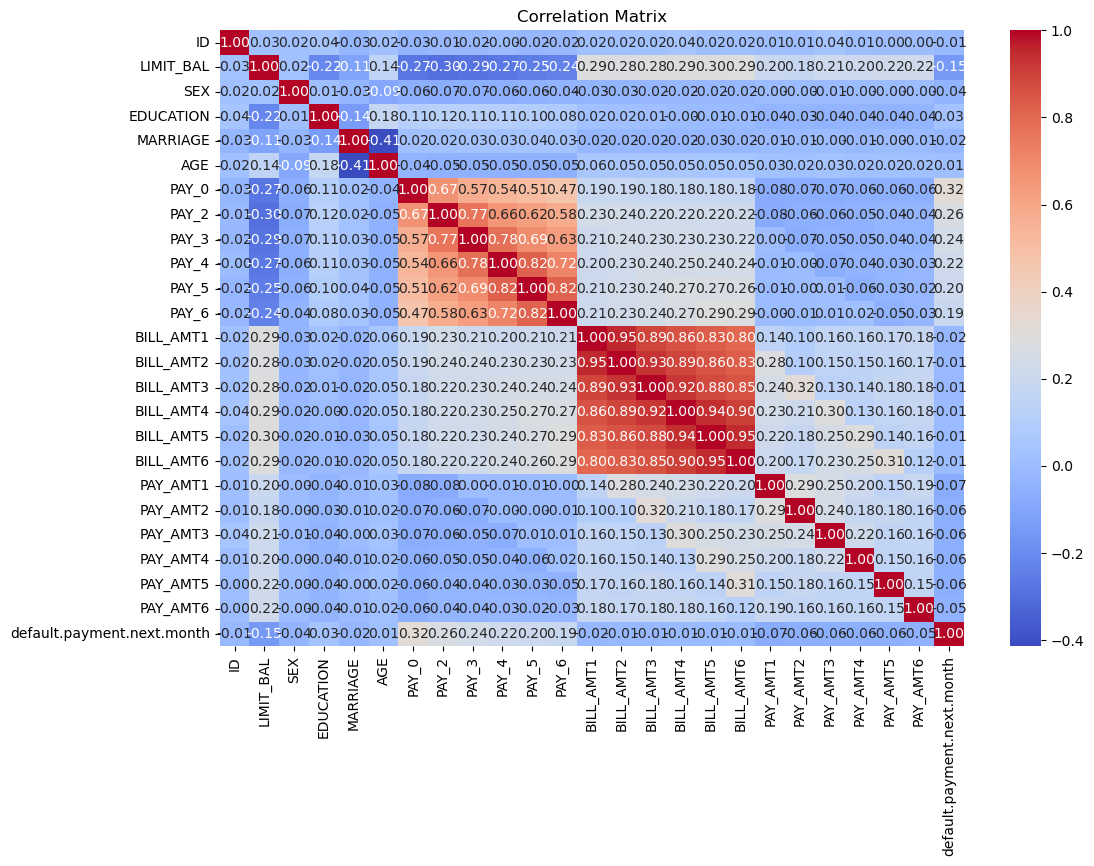

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr()
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [49]:
corr_with_target = df.corr()['default.payment.next.month'].sort_values(ascending=False)
print(corr_with_target)
#checking my target variable correlation with all other columns specifically


default.payment.next.month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDUCATION                     0.028006
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
ID                           -0.013952
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
MARRIAGE                     -0.024339
SEX                          -0.039961
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
Name: default.payment.nex

so my target variable is positively correlated with pay0,pay2,pay3,4,5,6
#and negatively correlated with limit balance(majority)
#so i am planning to apply mar to these values since the correlation of these variable with my target is more and i can test my model properly
 so i am choosing two positive correlated columns and two negatively correlated columns and keeping value nan i.e. emptying the cell and i have mentioned the no of cells made nan in each column

## 2. Create Missing At Random (MAR) values

We will introduce MAR missingness (~7%) into three numeric columns: `LIMIT_BAL` (this will be the column imputed via regression), `AGE`, and `BILL_AMT1`. To simulate MAR (not purely random), missingness probability will depend on another variable (`PAY_0`) so that missingness is correlated with observed data.

In [50]:
# Make a reproducible copy
np.random.seed(42)
df_missing = df.copy()

def introduce_mar(series, prob_func):
    mask = np.random.rand(len(series)) < prob_func
    s = series.copy()
    s[mask] = np.nan
    return s, mask.sum()

n = len(df_missing)

# Define probabilistic masks that depend on PAY_0 values (simulating MAR)
pay0 = df_missing['PAY_0'].fillna(0).astype(int)

# Probability arrays: base prob plus small increment for certain PAY_0 values
prob_limit = 0.07 + (np.isin(pay0, [1,2,3]).astype(float) * 0.05)  # higher missingness for certain pay statuses
prob_age   = 0.06 + (np.isin(pay0, [-1,0]).astype(float) * 0.02)
prob_bill1 = 0.07 + (np.isin(pay0, [2,3,4]).astype(float) * 0.04)

df_missing['LIMIT_BAL'], cnt_lim = introduce_mar(df_missing['LIMIT_BAL'], prob_limit)
df_missing['AGE'], cnt_age = introduce_mar(df_missing['AGE'], prob_age)
df_missing['BILL_AMT1'], cnt_bill = introduce_mar(df_missing['BILL_AMT1'], prob_bill1)

#cnt = {'LIMIT_BAL': cnt_lim, 'AGE': cnt_age, 'BILL_AMT1': cnt_bill}
#print('Introduced missing values count:', cnt)
#df_missing[['LIMIT_BAL','AGE','BILL_AMT1']].isna().mean()
print(df_missing.isnull().sum())


ID                               0
LIMIT_BAL                     2425
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           2201
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     2212
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


#### Explain the underlying assumption of this method (Missing At Random)?
These probability arrays define how likely each row is to become missing, based on another variable (here, PAY_0). Adding prob_limit, prob_age, prob_bill1 to make missingness depend on payment status (PAY_0) → that’s what makes it MAR.

## Part A: Imputation Strategies

We will create four datasets:
- Dataset A: Median imputation for all columns with missing values (baseline).
- Dataset B: Linear Regression imputation for `LIMIT_BAL` (only), median for other missing columns.
- Dataset C: Decision Tree Regression imputation for `LIMIT_BAL` (only), median for others.
- Dataset D: Listwise deletion (drop rows with any missing values).

In [51]:
from sklearn.base import clone

# Helper to prepare copies
dfA = df_missing.copy()
dfB = df_missing.copy()
dfC = df_missing.copy()

# Dataset A: median imputation for all numeric columns with missing values
num_cols = dfA.select_dtypes(include=[np.number]).columns.tolist()
median_imp = SimpleImputer(strategy='median')
dfA[num_cols] = median_imp.fit_transform(dfA[num_cols])

# For B and C: impute other columns (AGE, BILL_AMT1) with median, but keep LIMIT_BAL missing for regression imputation
for name in ['AGE','BILL_AMT1']:
    for dfcopy in (dfB, dfC):
        dfcopy[[name]] = median_imp.fit_transform(dfcopy[[name]])

# Leave LIMIT_BAL with NaNs in dfB and dfC for regression step
print('Missing in LIMIT_BAL — dfA, dfB, dfC:', dfA['LIMIT_BAL'].isna().sum(), dfB['LIMIT_BAL'].isna().sum(), dfC['LIMIT_BAL'].isna().sum())

Missing in LIMIT_BAL — dfA, dfB, dfC: 0 2425 2425


#### Explain why the median is often preferred over the mean for imputation?
The median is often preferred over the mean for imputation because it is robust to outliers and skewed distributions, representing the central tendency of the data more accurately in most real-world scenarios. Using the mean can distort the data when extreme values are present, whereas the median provides a stable and realistic substitute for missing values.

### 3. Linear Regression Imputation for `LIMIT_BAL` (Dataset B)
We will predict missing `LIMIT_BAL` values using a Linear Regression model trained on rows where `LIMIT_BAL` is observed. Features used: all other numeric columns (after simple median imputation where needed).

In [52]:
# Prepare training data for imputation (linear)
features = [c for c in dfB.select_dtypes(include=[np.number]).columns if c != 'LIMIT_BAL' and c != 'ID']  # exclude ID if present
# Rows where LIMIT_BAL observed
obs_mask = dfB['LIMIT_BAL'].notna()
X_obs = dfB.loc[obs_mask, features]
y_obs = dfB.loc[obs_mask, 'LIMIT_BAL']
X_miss = dfB.loc[~obs_mask, features]

print('Imputation training size (linear):', X_obs.shape)

linreg = LinearRegression()
linreg.fit(X_obs, y_obs)

# Predict and fill
dfB.loc[~obs_mask, 'LIMIT_BAL'] = linreg.predict(X_miss)

print('Filled missing LIMIT_BAL in dfB. Any remaining NaNs:', dfB['LIMIT_BAL'].isna().sum())

Imputation training size (linear): (27575, 23)
Filled missing LIMIT_BAL in dfB. Any remaining NaNs: 0


### 4. Decision Tree Regression Imputation for `LIMIT_BAL` (Dataset C)
We will use a `DecisionTreeRegressor` to impute missing `LIMIT_BAL` values. This non-linear model can capture interactions and splits that linear regression cannot.

In [53]:
# Prepare training data for imputation (decision tree)
obs_mask_c = dfC['LIMIT_BAL'].notna()
X_obs_c = dfC.loc[obs_mask_c, features]
y_obs_c = dfC.loc[obs_mask_c, 'LIMIT_BAL']
X_miss_c = dfC.loc[~obs_mask_c, features]

tree = DecisionTreeRegressor(random_state=42, max_depth=10)
tree.fit(X_obs_c, y_obs_c)

# Predict and fill
dfC.loc[~obs_mask_c, 'LIMIT_BAL'] = tree.predict(X_miss_c)
print('Filled missing LIMIT_BAL in dfC. Any remaining NaNs:', dfC['LIMIT_BAL'].isna().sum())

Filled missing LIMIT_BAL in dfC. Any remaining NaNs: 0


### 5. Dataset D: Listwise Deletion (drop rows with any missing values)

In [54]:
dfD = df_missing.dropna().reset_index(drop=True)
print('Dataset D shape after listwise deletion:', dfD.shape)

Dataset D shape after listwise deletion: (23682, 25)


## Part B: Model Training and Performance Assessment

For each dataset (A, B, C, D) we'll:
1. Split into train/test (80/20)
2. Standardize features
3. Train a Logistic Regression classifier to predict `default payment next month` (often labeled `default.payment.next.month` or `default`)
4. Evaluate using classification report (accuracy, precision, recall, f1-score)

In [57]:
# Prepare feature list: numeric features excluding ID and target
target='default.payment.next.month'
def prepare_Xy(df):
    X = df.select_dtypes(include=[np.number]).copy()
    if 'ID' in X.columns:
        X = X.drop(columns=['ID'])
    if target in X.columns:
        X = X.drop(columns=[target])
    y = df[target].astype(int)
    return X, y

X_A, y_A = prepare_Xy(dfA)
X_B, y_B = prepare_Xy(dfB)
X_C, y_C = prepare_Xy(dfC)
X_D, y_D = prepare_Xy(dfD)

print('Shapes:', X_A.shape, X_B.shape, X_C.shape, X_D.shape)

Shapes: (30000, 23) (30000, 23) (30000, 23) (23682, 23)


In [58]:
# Train/test split and scaling helper
from sklearn.pipeline import Pipeline

def train_and_evaluate(X, y, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

reports = {}
for name, (X,y) in [('A',(X_A,y_A)), ('B',(X_B,y_B)), ('C',(X_C,y_C)), ('D',(X_D,y_D))]:
    rep, acc, f1w = train_and_evaluate(X,y)
    reports[name] = {'report': rep, 'accuracy': acc, 'f1_weighted': f1w}
    print(f'Dataset {name}: accuracy={acc:.4f}, f1-weighted={f1w:.4f}')

Dataset A: accuracy=0.8075, f1-weighted=0.7691
Dataset B: accuracy=0.8072, f1-weighted=0.7689
Dataset C: accuracy=0.8065, f1-weighted=0.7678
Dataset D: accuracy=0.8115, f1-weighted=0.7690


## Part C: Comparative Analysis

Create a summary table comparing Accuracy and Weighted F1-score for Models A-D, followed by discussion cells.

In [59]:
summary_rows = []
for k,v in reports.items():
    summary_rows.append({'Dataset': k, 'Accuracy': v['accuracy'], 'F1_weighted': v['f1_weighted']})
summary_df = pd.DataFrame(summary_rows).set_index('Dataset')
display(summary_df)

,Accuracy,F1_weighted
Dataset,,
A,0.807500,0.769116
B,0.807167,0.768858
C,0.806500,0.767773
D,0.811484,0.768967


/var/folders/qm/_64hw5t97c9gvb7qd52l73p80000gn/T/ipykernel_9725/2566255732.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - bar_width/2, summary_df['Accuracy'][i] + 0.01,
/var/folders/qm/_64hw5t97c9gvb7qd52l73p80000gn/T/ipykernel_9725/2566255732.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{summary_df['Accuracy'][i]:.4f}", ha='center', fontsize=9)
/var/folders/qm/_64hw5t97c9gvb7qd52l73p80000gn/T/ipykernel_9725/2566255732.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

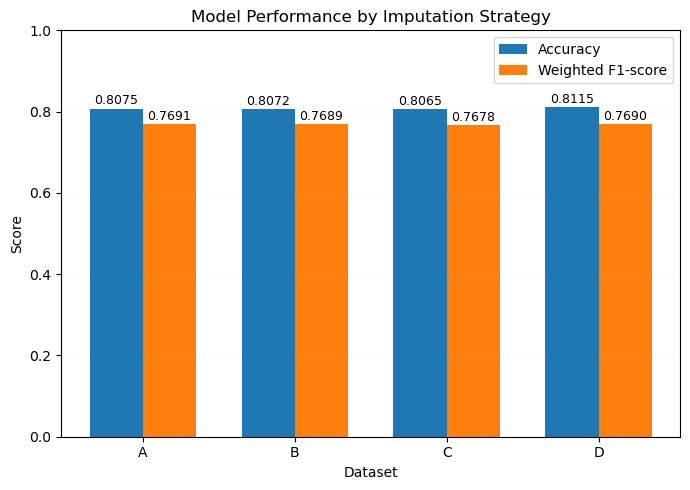

In [64]:
# Plot Accuracy and Weighted F1-scores side by side
plt.figure(figsize=(7,5))

# Bar width and x locations
bar_width = 0.35
x = np.arange(len(summary_df.index))

# Create bars for Accuracy and F1
plt.bar(x - bar_width/2, summary_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(x + bar_width/2, summary_df['F1_weighted'], width=bar_width, label='Weighted F1-score')

# Titles and labels
plt.title('Model Performance by Imputation Strategy')
plt.xlabel('Dataset')
plt.ylabel('Score')
plt.xticks(x, summary_df.index)
plt.ylim(0, 1)  # since both metrics range between 0–1
plt.grid(axis='y', linestyle=':', linewidth=0.1)

# Add values on top of bars
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, summary_df['Accuracy'][i] + 0.01, 
             f"{summary_df['Accuracy'][i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i] + bar_width/2, summary_df['F1_weighted'][i] + 0.01, 
             f"{summary_df['F1_weighted'][i]:.4f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


#### 1. Discuss the trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C). Why might Model D perform poorly even if the imputed models perform worse?

Listwise Deletion (D):
- When I drop all rows with missing data, I observe slightly higher accuracy (0.8115). However, this comes at a cost: if the missingness depends on important features (MAR/MNAR), my model may learn a biased or less generalizable pattern. That is, my model could perform poorly on new, more complete data or fail to capture groups most likely to have missingness.

Imputation (A, B, C):
- By imputing missing values, I keep all samples and preserve the original data size, increasing statistical power. This can introduce a different kind of bias if the method is inappropriate, but in my results, the drop in accuracy or F1 is minimal—about 0.5%—and all three imputed methods show similar performance. I generally prefer imputation unless missing values are very few and completely random.

Model D may perform poorly in real-life scenarios since with listwise deletion, I risk:

- Reduced data diversity: Fewer training examples may mean less robust predictions.

- Potential bias: If missingness relates to the target or features, my model learns from a filtered subset, which might not represent the true data population.


#### 2. Which regression method (Linear vs. Non-Linear) performed better and why? Relate this to the assumed relationship between the imputed feature and the predictors.

- Comparing linear regression imputation (B) and decision tree imputation (C), my results show linear regression (B) performing marginally better, though both methods yield nearly identical metrics.

- This suggests that in this dataset, the relationship between the imputed feature (LIMITBAL) and its predictors is mostly linear. Extra complexity from non-linear models, like decision trees, does not provide substantial improvement—possibly due to a simple underlying relationship or overfitting risks with a moderate-sized dataset.


#### 3. Conclude with a recommendation on the best strategy for handling missing datain this scenario, justifying your answer by referencing both the classification performance metrics and the conceptual implications of each method.

Based on my metrics and conceptual understanding:

- If I want to maximize sample size and make unbiased, robust predictions (which is crucial when missingness is not MCAR), I should use imputation—median or regression. Median is simple and performed almost as well as the more complex methods in my work.

- Linear regression imputation (Model B) was at least as good as median and a little better than tree imputation, indicating no significant non-linear advantage.

- Listwise deletion (Model D) gives a small accuracy boost but loses many cases, which can be dangerous if missingness is not random.

### Conclusion
Median or regression imputation (especially linear in this scenario) is the best compromise for me—preserving data, reducing bias, and yielding strong classification results. Listwise deletion may inflate accuracy by fitting to a limited, possibly non-representative subset and is not what I would recommend unless missingness is rare and truly random. I should always consider the probable missing-data mechanism and, if possible, complement single imputation with cross-validation or even multiple imputation for more robust results.

